In [35]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Load CSVs (features x samples format, so we need to transpose)
gene_df = pd.read_csv("../Updated_model_nd_dataset/processed_expression_FXS_OG.csv", index_col=0).T
meth_df = pd.read_csv("../Updated_model_nd_dataset/processed_methylation_FXS_OG.csv", index_col=0).T
cnv_df  = pd.read_csv("../Updated_model_nd_dataset/processed_cnv_FXS_OG.csv", index_col=0).T
scaler_meth = StandardScaler()
meth_df = pd.DataFrame(
    scaler_meth.fit_transform(meth_df.T).T,
    index=meth_df.index,
    columns=meth_df.columns
)

print("After transpose - Shapes (samples x features):")
print(f"gene_df: {gene_df.shape}")
print(f"meth_df: {meth_df.shape}")
print(f"cnv_df: {cnv_df.shape}")


After transpose - Shapes (samples x features):
gene_df: (205, 60660)
meth_df: (205, 396650)
cnv_df: (205, 56756)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [37]:
print("NaN counts:", gene_df.isna().sum().sum(),
      meth_df.isna().sum().sum(),
      cnv_df.isna().sum().sum())


NaN counts: 0 0 0


In [38]:
gene_df = gene_df.fillna(0.0)
meth_df = meth_df.fillna(0.0)
cnv_df  = cnv_df.fillna(0.0)


In [39]:
print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Align samples across all three omics
common = gene_df.index.intersection(meth_df.index).intersection(cnv_df.index)
gene_df = gene_df.loc[common]
meth_df = meth_df.loc[common]
cnv_df  = cnv_df.loc[common]

print("Shapes:", gene_df.shape, meth_df.shape, cnv_df.shape)
# Convert to float32 tensors
gene = torch.tensor(gene_df.values, dtype=torch.float32).to(device)
meth = torch.tensor(meth_df.values, dtype=torch.float32).to(device)
cnv  = torch.tensor(cnv_df.values, dtype=torch.float32).to(device)


Shapes: (205, 60660) (205, 396650) (205, 56756)
Shapes: (205, 60660) (205, 396650) (205, 56756)


Epoch 1/200 | Train Loss: 0.9401 | Val Loss: 1.7720
Epoch 10/200 | Train Loss: 1.2000 | Val Loss: 1.0556
Epoch 20/200 | Train Loss: 0.9701 | Val Loss: 0.9571
Epoch 30/200 | Train Loss: 0.9342 | Val Loss: 0.9460
Epoch 40/200 | Train Loss: 0.9317 | Val Loss: 0.9461
Early stopping triggered!


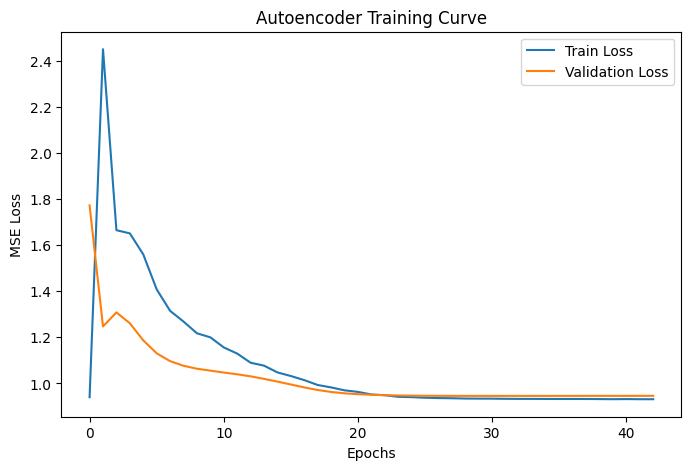

Epoch 1/200 | Train Loss: 1.0047 | Val Loss: 109.9151
Epoch 10/200 | Train Loss: 23.1294 | Val Loss: 7.3023
Epoch 20/200 | Train Loss: 6.2256 | Val Loss: 2.6242
Epoch 30/200 | Train Loss: 1.6299 | Val Loss: 1.1081
Epoch 40/200 | Train Loss: 1.0507 | Val Loss: 1.0238
Epoch 50/200 | Train Loss: 1.0232 | Val Loss: 1.0188
Epoch 60/200 | Train Loss: 1.0029 | Val Loss: 1.0185
Epoch 70/200 | Train Loss: 1.0007 | Val Loss: 1.0185
Early stopping triggered!


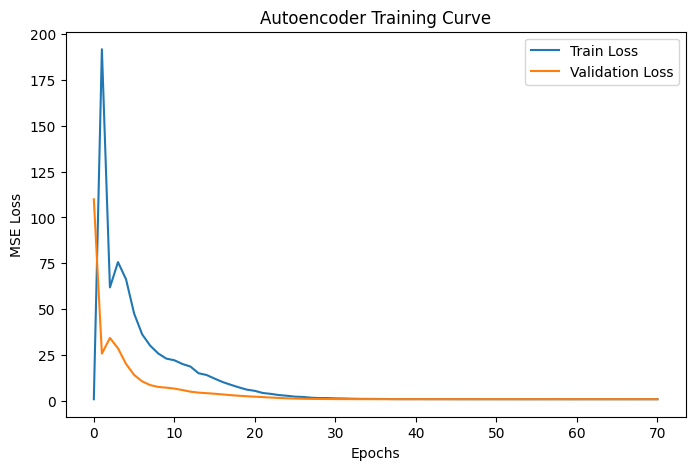

Epoch 1/200 | Train Loss: 1.0350 | Val Loss: 21.9022
Epoch 10/200 | Train Loss: 4.9896 | Val Loss: 1.5875
Epoch 20/200 | Train Loss: 1.9513 | Val Loss: 1.0192
Epoch 30/200 | Train Loss: 1.2280 | Val Loss: 0.9040
Epoch 40/200 | Train Loss: 1.0639 | Val Loss: 0.8950
Epoch 50/200 | Train Loss: 1.0316 | Val Loss: 0.8895
Epoch 60/200 | Train Loss: 1.0038 | Val Loss: 0.8631
Epoch 70/200 | Train Loss: 0.9594 | Val Loss: 0.8124
Epoch 80/200 | Train Loss: 0.8839 | Val Loss: 0.7445
Epoch 90/200 | Train Loss: 0.8147 | Val Loss: 0.6954
Epoch 100/200 | Train Loss: 0.7778 | Val Loss: 0.6674
Epoch 110/200 | Train Loss: 0.7638 | Val Loss: 0.6579
Epoch 120/200 | Train Loss: 0.7402 | Val Loss: 0.6495
Epoch 130/200 | Train Loss: 0.7435 | Val Loss: 0.6455
Epoch 140/200 | Train Loss: 0.7158 | Val Loss: 0.6403
Epoch 150/200 | Train Loss: 0.7221 | Val Loss: 0.6407
Epoch 160/200 | Train Loss: 0.7180 | Val Loss: 0.6427
Epoch 170/200 | Train Loss: 0.7223 | Val Loss: 0.6290
Epoch 180/200 | Train Loss: 0.6967 | V

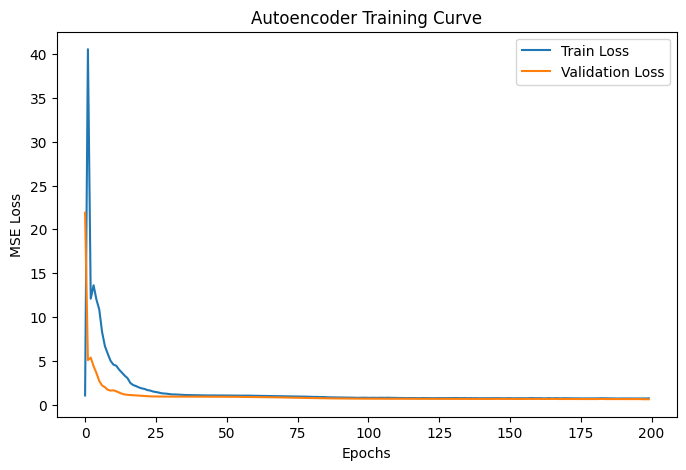

Individual latent shapes:
  - Gene latent: torch.Size([205, 64])
  - Methylation latent: torch.Size([205, 64])
  - CNV latent: torch.Size([205, 64])


In [42]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------ Autoencoder with Dropout ------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, dropout=0.3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

# ------------------ Training with validation & early stopping ------------------
def train_autoencoder(model, data, epochs=200, patience=10, normalize=True):
    # Optionally normalize features to mean=0, std=1
    if normalize:
        scaler = StandardScaler()
        data_np = scaler.fit_transform(data.cpu().numpy())
    else:
        data_np = data.cpu().numpy()

    # Split into train/val
    X_train, X_val = train_test_split(data_np, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val, dtype=torch.float32).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 reg
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = np.inf
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        z, recon = model(X_train)
        loss = criterion(recon, X_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            _, val_recon = model(X_val)
            val_loss = criterion(val_recon, X_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Autoencoder Training Curve")
    plt.legend()
    plt.show()

    return model

# ------------------ Train per omic ------------------
gene_dim, meth_dim, cnv_dim = gene.shape[1], meth.shape[1], cnv.shape[1]

ae_gene = Autoencoder(gene_dim, latent_dim=64).to(device)
ae_meth = Autoencoder(meth_dim, latent_dim=64).to(device)
ae_cnv  = Autoencoder(cnv_dim,  latent_dim=64).to(device)

ae_gene = train_autoencoder(ae_gene, gene, normalize=True)
ae_meth = train_autoencoder(ae_meth, meth, normalize=True)
ae_cnv  = train_autoencoder(ae_cnv, cnv, normalize=True)

# ------------------ Extract latent embeddings (NO FUSION) ------------------
ae_gene.eval(); ae_meth.eval(); ae_cnv.eval()
with torch.no_grad():
    z_gene, _ = ae_gene(gene.to(device))
    z_meth, _ = ae_meth(meth.to(device))
    z_cnv,  _ = ae_cnv(cnv.to(device))

print("Individual latent shapes:")
print(f"  - Gene latent: {z_gene.shape}")
print(f"  - Methylation latent: {z_meth.shape}")
print(f"  - CNV latent: {z_cnv.shape}")


# Individual Omics Machine Learning Evaluation

Train multiple classifiers on each individual omic's latent embeddings separately and compare performance.

In [43]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
import seaborn as sns

# Load subtype labels
labels_df = pd.read_csv("../Updated_model_nd_dataset/processed_labels_3Omics_FXS_OG.csv", index_col=0)

# Align labels with our data
common_samples = gene_df.index.intersection(labels_df.index)
print(f"Samples with labels: {len(common_samples)}")

# Get labels
labels = labels_df.loc[common_samples].values.ravel()

print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Class distribution: {np.bincount(labels.astype(int))}")

# Prepare individual omics embeddings
omics_data = {
    'Gene Expression': z_gene.cpu().numpy(),
    'Methylation': z_meth.cpu().numpy(),
    'Copy Number Variation': z_cnv.cpu().numpy()
}

print("\nIndividual omics embedding shapes:")
for name, data in omics_data.items():
    print(f"  {name}: {data.shape}")

Samples with labels: 205
Labels shape: (205,)
Unique classes: [0 1 2 3]
Class distribution: [53 22 96 34]

Individual omics embedding shapes:
  Gene Expression: (205, 64)
  Methylation: (205, 64)
  Copy Number Variation: (205, 64)


In [44]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Store all results in a dictionary
all_results = {}

print("="*100)
print("TRAINING AND EVALUATING INDIVIDUAL OMICS")
print("="*100)

# Train and evaluate models on each omic separately
for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"Processing: {omic_name}")
    print(f"{'='*100}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        omic_data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples\n")
    
    # Store results for this omic
    omic_results = []
    
    for model_name, clf in classifiers.items():
        print(f"  Training {model_name}...", end=' ')
        
        # Train the model
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
        precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
        recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
        recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
        f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
        
        omic_results.append({
            'Omic': omic_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision (Macro)': precision_macro,
            'Precision (Micro)': precision_micro,
            'Recall (Macro)': recall_macro,
            'Recall (Micro)': recall_micro,
            'F1 (Macro)': f1_macro,
            'F1 (Micro)': f1_micro
        })
        
        print(f"Accuracy: {accuracy:.4f}, F1-Macro: {f1_macro:.4f}")
    
    # Store results for this omic
    all_results[omic_name] = omic_results

print(f"\n{'='*100}")
print("✅ All individual omics evaluated!")
print(f"{'='*100}")

TRAINING AND EVALUATING INDIVIDUAL OMICS

Processing: Gene Expression
Training set: 164 samples
Test set: 41 samples

  Training Random Forest... Accuracy: 0.5854, F1-Macro: 0.3075
  Training Gradient Boosting... Accuracy: 0.5610, F1-Macro: 0.4317
  Training SVM (RBF)... Accuracy: 0.4634, F1-Macro: 0.1583
  Training Logistic Regression... 

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6098, F1-Macro: 0.4391
  Training KNN... Accuracy: 0.5610, F1-Macro: 0.3800
  Training Naive Bayes... Accuracy: 0.4634, F1-Macro: 0.3714

Processing: Methylation
Training set: 164 samples
Test set: 41 samples

  Training Random Forest... Accuracy: 0.6098, F1-Macro: 0.4696
  Training Gradient Boosting... Accuracy: 0.6341, F1-Macro: 0.4268
  Training SVM (RBF)... Accuracy: 0.4634, F1-Macro: 0.1583
  Training Logistic Regression... 

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6585, F1-Macro: 0.5458
  Training KNN... Accuracy: 0.6098, F1-Macro: 0.4244
  Training Naive Bayes... Accuracy: 0.4390, F1-Macro: 0.4041

Processing: Copy Number Variation
Training set: 164 samples
Test set: 41 samples

  Training Random Forest... Accuracy: 0.5610, F1-Macro: 0.3480
  Training Gradient Boosting... Accuracy: 0.4146, F1-Macro: 0.2342
  Training SVM (RBF)... Accuracy: 0.4878, F1-Macro: 0.2293
  Training Logistic Regression... 

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.5122, F1-Macro: 0.3157
  Training KNN... Accuracy: 0.5854, F1-Macro: 0.3920
  Training Naive Bayes... Accuracy: 0.4634, F1-Macro: 0.3236

✅ All individual omics evaluated!


# Deep Learning Models: MLP and GAT

Train MLP (Multi-Layer Perceptron) and GAT (Graph Attention Network) on individual omics embeddings.

In [45]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch.utils.data import DataLoader, TensorDataset

# ------------------ MLP Classifier ------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], num_classes=3, dropout=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# ------------------ GAT Classifier ------------------
class GATClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=3, heads=4, dropout=0.3):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x

# ------------------ Training Function for MLP ------------------
def train_mlp(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.001, patience=15):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)
    
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_preds = torch.max(val_outputs, 1)
            val_acc = (val_preds == y_val_tensor).float().mean().item()
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model

# ------------------ Training Function for GAT ------------------
# Improved GAT with consistent graph construction
def train_gat(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.001, patience=15, k=7):
    """
    Improved GAT training with:
    - Adaptive k based on sample size
    - Consistent graph structure
    - Better initialization
    """
    from torch_geometric.nn import knn_graph
    
    # Adjust k based on sample size (k should be < sqrt(n_samples))
    max_k = int(np.sqrt(len(X_train)))
    k = min(k, max_k)
    print(f"📊 Using k={k} for KNN graph (max_k={max_k})")
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)
    
    # Create KNN graphs once (more consistent)
    print(f"🔗 Building KNN graphs...")
    edge_index_train = knn_graph(X_train_tensor, k=k, loop=False)
    edge_index_val = knn_graph(X_val_tensor, k=k, loop=False)
    print(f"✅ Train graph edges: {edge_index_train.shape[1]}, Val graph edges: {edge_index_val.shape[1]}")
    
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor, edge_index_train)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor, edge_index_val)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_preds = torch.max(val_outputs, 1)
            val_acc = (val_preds == y_val_tensor).float().mean().item()
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️  Early stopping at epoch {epoch+1}")
                break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    print(f"✅ Best validation accuracy: {best_val_acc:.4f}")
    return model
print("✅ MLP and GAT architectures defined!")

✅ MLP and GAT architectures defined!


In [46]:
# Train MLP on individual omics
mlp_results = {}

print("="*100)
print("TRAINING MLP ON INDIVIDUAL OMICS")
print("="*100)

num_classes = len(np.unique(labels))

for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"Processing: {omic_name}")
    print(f"{'='*100}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        omic_data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Further split train into train/val
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Training set: {X_train_split.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Initialize and train MLP
    input_dim = omic_data.shape[1]
    mlp_model = MLPClassifier(input_dim=input_dim, hidden_dims=[128, 64], 
                               num_classes=num_classes, dropout=0.3).to(device)
    
    print(f"Training MLP...")
    mlp_model = train_mlp(mlp_model, X_train_split, y_train_split, X_val, y_val, 
                          epochs=100, lr=0.001, patience=15)
    
    # Evaluate on test set
    mlp_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        test_outputs = mlp_model(X_test_tensor)
        _, y_pred = torch.max(test_outputs, 1)
        y_pred = y_pred.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    mlp_results[omic_name] = {
        'Omic': omic_name,
        'Model': 'MLP',
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro
    }
    
    print(f"✅ MLP Results - Accuracy: {accuracy:.4f}, F1-Macro: {f1_macro:.4f}")

print(f"\n{'='*100}")
print("✅ MLP training completed for all omics!")
print(f"{'='*100}")

TRAINING MLP ON INDIVIDUAL OMICS

Processing: Gene Expression
Training set: 131 samples
Validation set: 33 samples
Test set: 41 samples
Training MLP...
✅ MLP Results - Accuracy: 0.6829, F1-Macro: 0.3984

Processing: Methylation
Training set: 131 samples
Validation set: 33 samples
Test set: 41 samples
Training MLP...
✅ MLP Results - Accuracy: 0.4634, F1-Macro: 0.1610

Processing: Copy Number Variation
Training set: 131 samples
Validation set: 33 samples
Test set: 41 samples
Training MLP...
✅ MLP Results - Accuracy: 0.4634, F1-Macro: 0.2505

✅ MLP training completed for all omics!


In [47]:
# Train GAT on individual omics
gat_results = {}

print("="*100)
print("TRAINING GAT ON INDIVIDUAL OMICS")
print("="*100)

for omic_name, omic_data in omics_data.items():
    print(f"\n{'='*100}")
    print(f"Processing: {omic_name}")
    print(f"{'='*100}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        omic_data, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Further split train into train/val
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Training set: {X_train_split.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Initialize and train GAT
    input_dim = omic_data.shape[1]
    gat_model = GATClassifier(input_dim=input_dim, hidden_dim=64, 
                               num_classes=num_classes, heads=4, dropout=0.3).to(device)
    
    print(f"Training GAT...")
    gat_model = train_gat(gat_model, X_train_split, y_train_split, X_val, y_val, 
                          epochs=100, lr=0.001, patience=15, k=5)
    
    # Evaluate on test set
    gat_model.eval()
    with torch.no_grad():
        from torch_geometric.nn import knn_graph
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        edge_index_test = knn_graph(X_test_tensor, k=5, loop=False)
        test_outputs = gat_model(X_test_tensor, edge_index_test)
        _, y_pred = torch.max(test_outputs, 1)
        y_pred = y_pred.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    gat_results[omic_name] = {
        'Omic': omic_name,
        'Model': 'GAT',
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro
    }
    
    print(f"✅ GAT Results - Accuracy: {accuracy:.4f}, F1-Macro: {f1_macro:.4f}")

print(f"\n{'='*100}")
print("✅ GAT training completed for all omics!")
print(f"{'='*100}")

TRAINING GAT ON INDIVIDUAL OMICS

Processing: Gene Expression
Training set: 131 samples
Validation set: 33 samples
Test set: 41 samples
Training GAT...
📊 Using k=5 for KNN graph (max_k=11)
🔗 Building KNN graphs...
✅ Train graph edges: 655, Val graph edges: 165
Epoch 20/100 - Train Loss: 2.1502, Val Loss: 1.2631, Val Acc: 0.5152
⏹️  Early stopping at epoch 23
✅ Best validation accuracy: 0.5152
✅ GAT Results - Accuracy: 0.4634, F1-Macro: 0.1583

Processing: Methylation
Training set: 131 samples
Validation set: 33 samples
Test set: 41 samples
Training GAT...
📊 Using k=5 for KNN graph (max_k=11)
🔗 Building KNN graphs...
✅ Train graph edges: 655, Val graph edges: 165
⏹️  Early stopping at epoch 16
✅ Best validation accuracy: 0.4848
✅ GAT Results - Accuracy: 0.4634, F1-Macro: 0.1583

Processing: Copy Number Variation
Training set: 131 samples
Validation set: 33 samples
Test set: 41 samples
Training GAT...
📊 Using k=5 for KNN graph (max_k=11)
🔗 Building KNN graphs...
✅ Train graph edges: 655,


📊 TABLE 2: MLP RESULTS ON INDIVIDUAL OMICS

📋 Complete MLP Results:
----------------------------------------------------------------------------------------------------
                 Omic Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
      Gene Expression   MLP    0.6829             0.3565             0.6829          0.4545          0.6829      0.3984      0.6829
          Methylation   MLP    0.4634             0.1187             0.4634          0.2500          0.4634      0.1610      0.4634
Copy Number Variation   MLP    0.4634             0.2248             0.4634          0.2883          0.4634      0.2505      0.4634


📊 MLP F1-MACRO SCORES BY OMIC
----------------------------------------------------------------------------------------------------
                 Omic  F1 (Macro)
      Gene Expression      0.3984
Copy Number Variation      0.2505
          Methylation      0.1610


📊 MLP ACCURACY SCORES BY OMIC
-

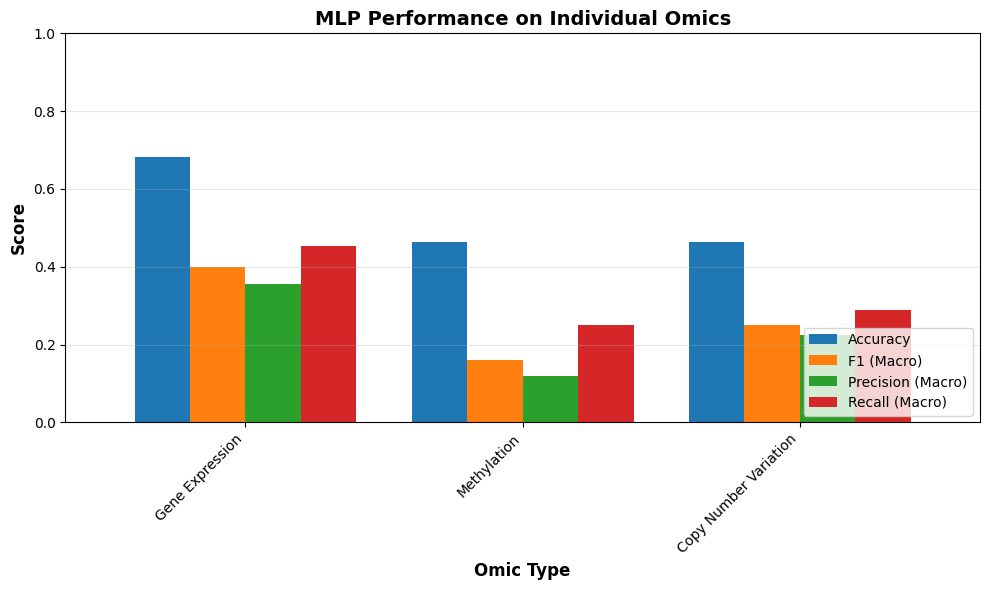


✅ MLP results visualization completed!


In [48]:
# TABLE 2: MLP Results Comparison
print("\n" + "="*100)
print("📊 TABLE 2: MLP RESULTS ON INDIVIDUAL OMICS")
print("="*100)

# Create DataFrame for MLP results
mlp_results_list = list(mlp_results.values())
mlp_df = pd.DataFrame(mlp_results_list)

print("\n📋 Complete MLP Results:")
print("-"*100)
pd.set_option('display.float_format', '{:.4f}'.format)
print(mlp_df.to_string(index=False))

# MLP F1-Score Comparison
print("\n\n📊 MLP F1-MACRO SCORES BY OMIC")
print("-"*100)
mlp_f1 = mlp_df[['Omic', 'F1 (Macro)']].sort_values('F1 (Macro)', ascending=False)
print(mlp_f1.to_string(index=False))

# MLP Accuracy Comparison
print("\n\n📊 MLP ACCURACY SCORES BY OMIC")
print("-"*100)
mlp_acc = mlp_df[['Omic', 'Accuracy']].sort_values('Accuracy', ascending=False)
print(mlp_acc.to_string(index=False))

# Best performing omic for MLP
print("\n\n🏆 BEST PERFORMING OMIC FOR MLP")
print("-"*100)
best_mlp = mlp_df.loc[mlp_df['F1 (Macro)'].idxmax()]
print(f"Omic: {best_mlp['Omic']}")
print(f"Accuracy: {best_mlp['Accuracy']:.4f}")
print(f"F1-Macro: {best_mlp['F1 (Macro)']:.4f}")
print(f"Precision-Macro: {best_mlp['Precision (Macro)']:.4f}")
print(f"Recall-Macro: {best_mlp['Recall (Macro)']:.4f}")

# Visualize MLP results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
mlp_metrics = mlp_df[['Omic', 'Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']]
mlp_metrics_plot = mlp_metrics.set_index('Omic')
mlp_metrics_plot.plot(kind='bar', ax=ax, width=0.8)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Omic Type', fontsize=12, fontweight='bold')
ax.set_title('MLP Performance on Individual Omics', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✅ MLP results visualization completed!")


📊 TABLE 3: GAT RESULTS ON INDIVIDUAL OMICS

📋 Complete GAT Results:
----------------------------------------------------------------------------------------------------
                 Omic Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
      Gene Expression   GAT    0.4634             0.1159             0.4634          0.2500          0.4634      0.1583      0.4634
          Methylation   GAT    0.4634             0.1159             0.4634          0.2500          0.4634      0.1583      0.4634
Copy Number Variation   GAT    0.4634             0.2292             0.4634          0.3628          0.4634      0.2676      0.4634


📊 GAT F1-MACRO SCORES BY OMIC
----------------------------------------------------------------------------------------------------
                 Omic  F1 (Macro)
Copy Number Variation      0.2676
      Gene Expression      0.1583
          Methylation      0.1583


📊 GAT ACCURACY SCORES BY OMIC
-

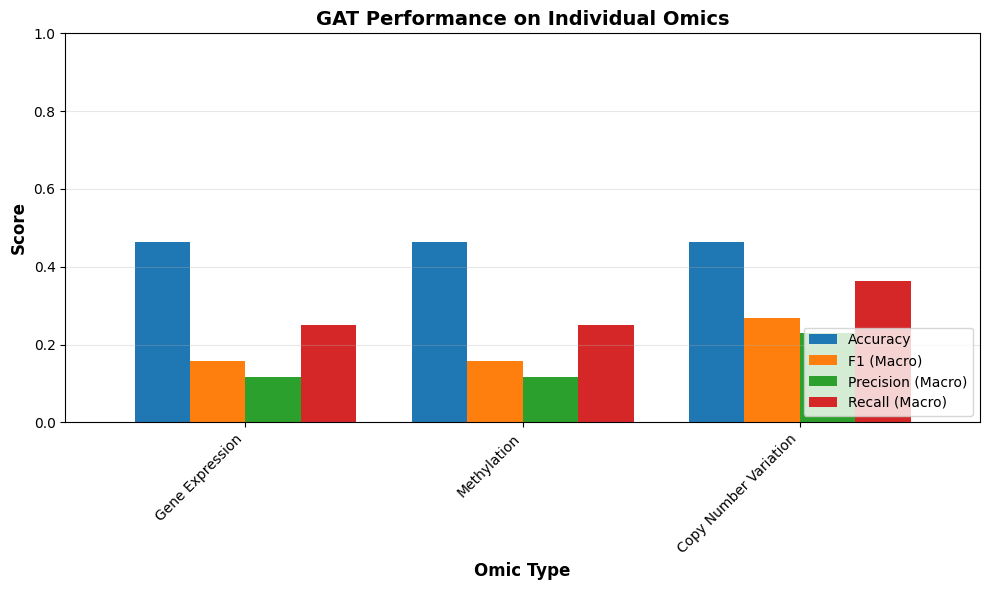


✅ GAT results visualization completed!


In [49]:
# TABLE 3: GAT Results Comparison
print("\n" + "="*100)
print("📊 TABLE 3: GAT RESULTS ON INDIVIDUAL OMICS")
print("="*100)

# Create DataFrame for GAT results
gat_results_list = list(gat_results.values())
gat_df = pd.DataFrame(gat_results_list)

print("\n📋 Complete GAT Results:")
print("-"*100)
pd.set_option('display.float_format', '{:.4f}'.format)
print(gat_df.to_string(index=False))

# GAT F1-Score Comparison
print("\n\n📊 GAT F1-MACRO SCORES BY OMIC")
print("-"*100)
gat_f1 = gat_df[['Omic', 'F1 (Macro)']].sort_values('F1 (Macro)', ascending=False)
print(gat_f1.to_string(index=False))

# GAT Accuracy Comparison
print("\n\n📊 GAT ACCURACY SCORES BY OMIC")
print("-"*100)
gat_acc = gat_df[['Omic', 'Accuracy']].sort_values('Accuracy', ascending=False)
print(gat_acc.to_string(index=False))

# Best performing omic for GAT
print("\n\n🏆 BEST PERFORMING OMIC FOR GAT")
print("-"*100)
best_gat = gat_df.loc[gat_df['F1 (Macro)'].idxmax()]
print(f"Omic: {best_gat['Omic']}")
print(f"Accuracy: {best_gat['Accuracy']:.4f}")
print(f"F1-Macro: {best_gat['F1 (Macro)']:.4f}")
print(f"Precision-Macro: {best_gat['Precision (Macro)']:.4f}")
print(f"Recall-Macro: {best_gat['Recall (Macro)']:.4f}")

# Visualize GAT results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gat_metrics = gat_df[['Omic', 'Accuracy', 'F1 (Macro)', 'Precision (Macro)', 'Recall (Macro)']]
gat_metrics_plot = gat_metrics.set_index('Omic')
gat_metrics_plot.plot(kind='bar', ax=ax, width=0.8)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Omic Type', fontsize=12, fontweight='bold')
ax.set_title('GAT Performance on Individual Omics', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✅ GAT results visualization completed!")


📊 OVERALL COMPARISON: TRADITIONAL ML vs MLP vs GAT

📋 F1-Macro Score Comparison
----------------------------------------------------------------------------------------------------
Method                   GAT    MLP  Traditional ML (KNN)  Traditional ML (Logistic Regression)
Omic                                                                                           
Copy Number Variation 0.2676 0.2505                0.3920                                   NaN
Gene Expression       0.1583 0.3984                   NaN                                0.4391
Methylation           0.1583 0.1610                   NaN                                0.5458

📋 Accuracy Comparison
----------------------------------------------------------------------------------------------------
Method                   GAT    MLP  Traditional ML (KNN)  Traditional ML (Logistic Regression)
Omic                                                                                           
Copy Number Variation 

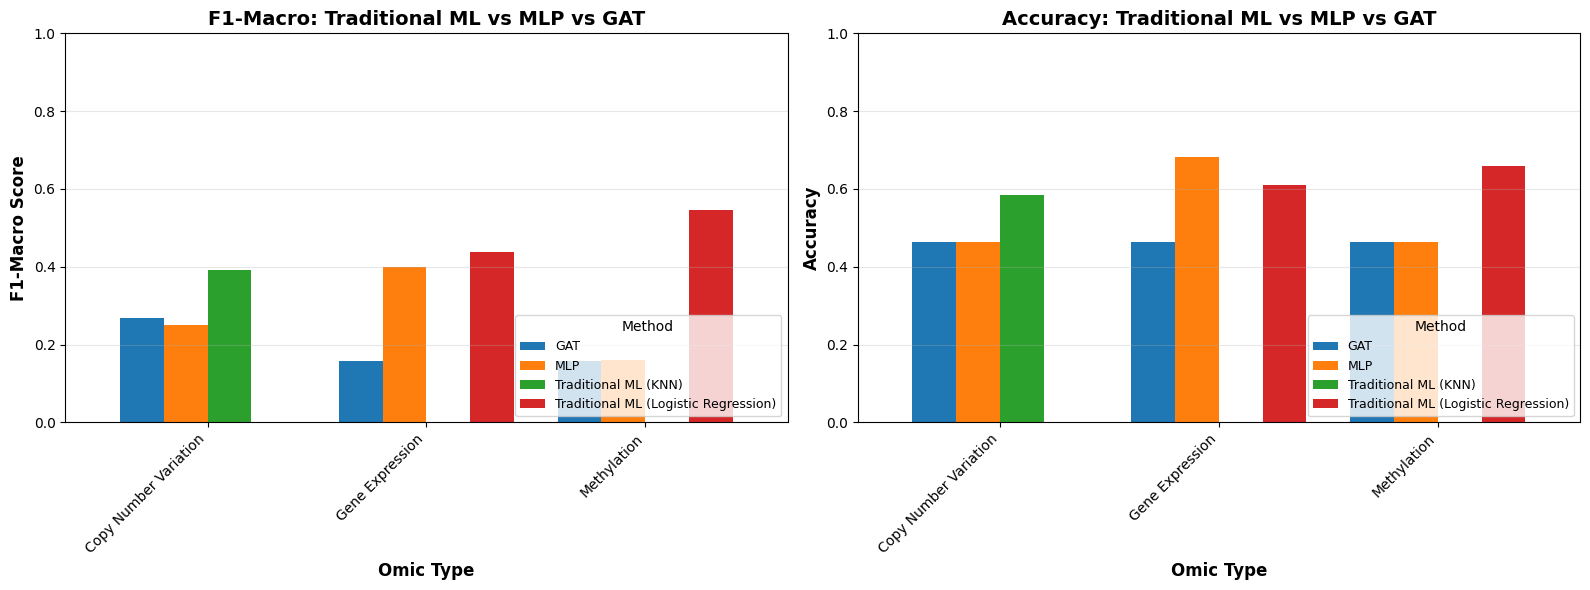



🏆 BEST METHOD FOR EACH OMIC
----------------------------------------------------------------------------------------------------
                 Omic                               Method  F1 (Macro)  Accuracy
Copy Number Variation                 Traditional ML (KNN)      0.3920    0.5854
      Gene Expression Traditional ML (Logistic Regression)      0.4391    0.6098
          Methylation Traditional ML (Logistic Regression)      0.5458    0.6585

✅ Overall comparison completed!


In [50]:
# Combined Comparison: Traditional ML vs MLP vs GAT
print("\n" + "="*100)
print("📊 OVERALL COMPARISON: TRADITIONAL ML vs MLP vs GAT")
print("="*100)

# Get best traditional ML result per omic
traditional_best = []
for omic_name in omics_data.keys():
    omic_results = [r for r in all_results[omic_name]]
    omic_results_df = pd.DataFrame(omic_results)
    best = omic_results_df.loc[omic_results_df['F1 (Macro)'].idxmax()]
    traditional_best.append({
        'Omic': omic_name,
        'Method': f'Traditional ML ({best["Model"]})',
        'F1 (Macro)': best['F1 (Macro)'],
        'Accuracy': best['Accuracy']
    })

# Combine all results
comparison_data = []
comparison_data.extend(traditional_best)

for omic_name in omics_data.keys():
    comparison_data.append({
        'Omic': omic_name,
        'Method': 'MLP',
        'F1 (Macro)': mlp_results[omic_name]['F1 (Macro)'],
        'Accuracy': mlp_results[omic_name]['Accuracy']
    })
    comparison_data.append({
        'Omic': omic_name,
        'Method': 'GAT',
        'F1 (Macro)': gat_results[omic_name]['F1 (Macro)'],
        'Accuracy': gat_results[omic_name]['Accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n📋 F1-Macro Score Comparison")
print("-"*100)
comparison_pivot = comparison_df.pivot(index='Omic', columns='Method', values='F1 (Macro)')
print(comparison_pivot.to_string())

print("\n📋 Accuracy Comparison")
print("-"*100)
accuracy_comparison_pivot = comparison_df.pivot(index='Omic', columns='Method', values='Accuracy')
print(accuracy_comparison_pivot.to_string())

# Visualize combined comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1-Macro comparison
ax1 = axes[0]
comparison_pivot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_ylabel('F1-Macro Score', fontsize=12, fontweight='bold')
ax1.set_xlabel('Omic Type', fontsize=12, fontweight='bold')
ax1.set_title('F1-Macro: Traditional ML vs MLP vs GAT', fontsize=14, fontweight='bold')
ax1.legend(title='Method', loc='lower right', fontsize=9)
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Accuracy comparison
ax2 = axes[1]
accuracy_comparison_pivot.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_xlabel('Omic Type', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy: Traditional ML vs MLP vs GAT', fontsize=14, fontweight='bold')
ax2.legend(title='Method', loc='lower right', fontsize=9)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Overall best method per omic
print("\n\n🏆 BEST METHOD FOR EACH OMIC")
print("-"*100)
best_method_per_omic = comparison_df.loc[comparison_df.groupby('Omic')['F1 (Macro)'].idxmax()]
print(best_method_per_omic[['Omic', 'Method', 'F1 (Macro)', 'Accuracy']].to_string(index=False))

print("\n✅ Overall comparison completed!")

In [54]:
# Create comprehensive comparison tables
print("\n" + "="*100)
print("RESULTS COMPARISON TABLES")
print("="*100)

# Combine all results into a single DataFrame
all_results_list = []
for omic_name, results in all_results.items():
    all_results_list.extend(results)

results_df = pd.DataFrame(all_results_list)

# TABLE 1: Complete Results
print("\n📊 TABLE 1: COMPLETE RESULTS (All Metrics)")
print("-"*100)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print(results_df.to_string(index=False))




RESULTS COMPARISON TABLES

📊 TABLE 1: COMPLETE RESULTS (All Metrics)
----------------------------------------------------------------------------------------------------
                 Omic               Model  Accuracy  Precision (Macro)  Precision (Micro)  Recall (Macro)  Recall (Micro)  F1 (Macro)  F1 (Micro)
      Gene Expression       Random Forest    0.5854             0.2720             0.5854          0.3636          0.5854      0.3075      0.5854
      Gene Expression   Gradient Boosting    0.5610             0.4097             0.5610          0.4633          0.5610      0.4317      0.5610
      Gene Expression           SVM (RBF)    0.4634             0.1159             0.4634          0.2500          0.4634      0.1583      0.4634
      Gene Expression Logistic Regression    0.6098             0.4373             0.6098          0.4506          0.6098      0.4391      0.6098
      Gene Expression                 KNN    0.5610             0.3496             0.5610          


VISUALIZATION: F1-MACRO SCORE COMPARISON


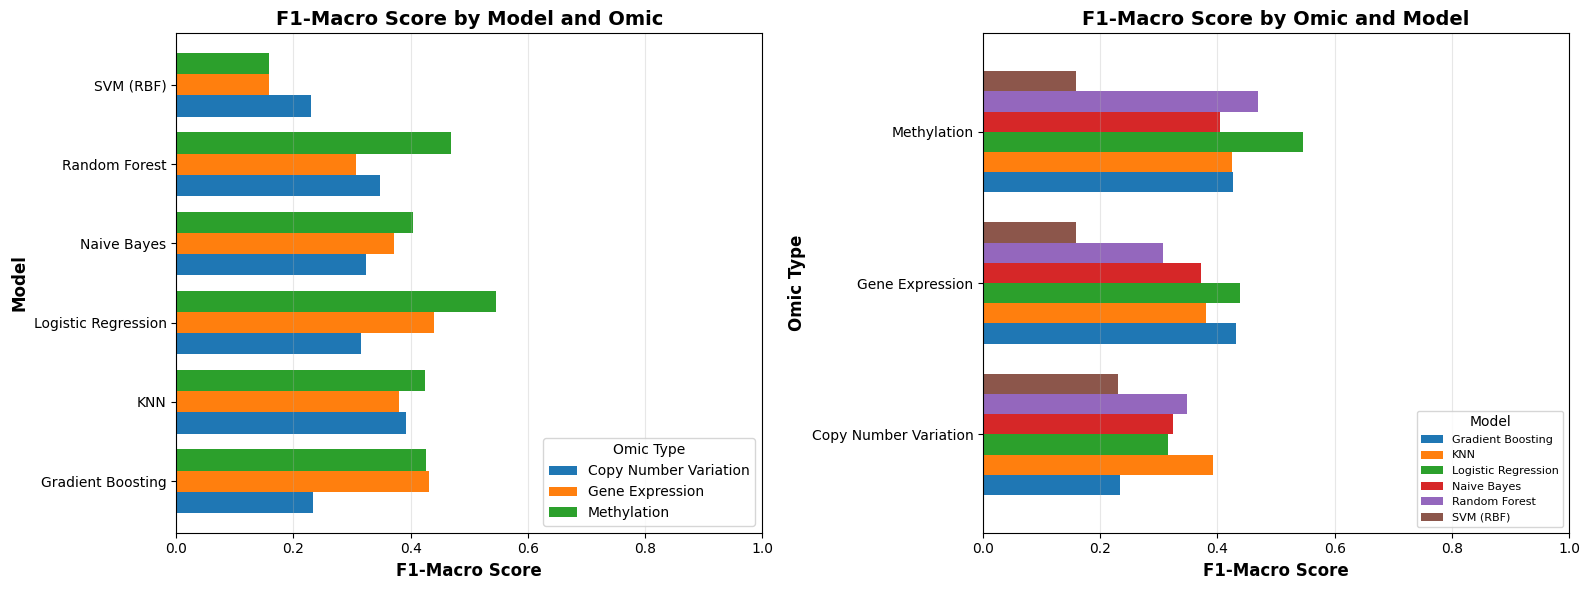


✅ Visualization completed!


In [52]:
# Visualize F1-Score Comparison
print("\n" + "="*100)
print("VISUALIZATION: F1-MACRO SCORE COMPARISON")
print("="*100)

# Create bar plot comparing F1 scores across omics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1-Macro scores grouped by Model
ax1 = axes[0]
f1_data = results_df.pivot(index='Model', columns='Omic', values='F1 (Macro)')
f1_data.plot(kind='barh', ax=ax1, width=0.8)
ax1.set_xlabel('F1-Macro Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Model', fontsize=12, fontweight='bold')
ax1.set_title('F1-Macro Score by Model and Omic', fontsize=14, fontweight='bold')
ax1.legend(title='Omic Type', loc='lower right')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)

# Plot 2: F1-Macro scores grouped by Omic
ax2 = axes[1]
f1_data_transposed = results_df.pivot(index='Omic', columns='Model', values='F1 (Macro)')
f1_data_transposed.plot(kind='barh', ax=ax2, width=0.8)
ax2.set_xlabel('F1-Macro Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Omic Type', fontsize=12, fontweight='bold')
ax2.set_title('F1-Macro Score by Omic and Model', fontsize=14, fontweight='bold')
ax2.legend(title='Model', loc='lower right', fontsize=8)
ax2.set_xlim([0, 1])
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed!")

In [53]:
# Export results to CSV
results_df.to_csv("individual_omics_results.csv", index=False)
f1_pivot.to_csv("individual_omics_f1_comparison.csv")
accuracy_pivot.to_csv("individual_omics_accuracy_comparison.csv")

print("="*100)
print("💾 RESULTS EXPORTED")
print("="*100)
print("Files saved:")
print("  • individual_omics_results.csv")
print("  • individual_omics_f1_comparison.csv")
print("  • individual_omics_accuracy_comparison.csv")
print("\n✅ Analysis complete!")

💾 RESULTS EXPORTED
Files saved:
  • individual_omics_results.csv
  • individual_omics_f1_comparison.csv
  • individual_omics_accuracy_comparison.csv

✅ Analysis complete!
